In [22]:
!nvidia-smi

Fri Jul  1 08:47:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |    432MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
os.chdir('/content/drive/MyDrive/My Community session/Projects')
os.getcwd()

'/content/drive/MyDrive/My Community session/Projects'

In [25]:
data_path = "/content/drive/MyDrive/My Community session/data/job_intents.json"

In [26]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import json
import pickle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Text Preprocessing

In [27]:
words=[] #all unique words
classes = []  #all classed
documents = [] #all input with label
ignore_words = ['?', '!']

data_file = open(data_path, encoding='utf-8').read()
intents = json.loads(data_file)

In [28]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        w = nltk.word_tokenize(pattern)
        words.extend(w)

        documents.append((w, intent['tag']))


        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [29]:
lemmatizer = WordNetLemmatizer()

In [30]:
lm_words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]

In [31]:
lm_words = sorted(list(set(lm_words)))
lm_words

["'s",
 ',',
 'about',
 'africa',
 'anyone',
 'are',
 'awesome',
 'bye',
 'can',
 'day',
 'do',
 'ekse',
 'fact',
 'for',
 'give',
 'good',
 'goodbye',
 'hello',
 'help',
 'helpful',
 'helping',
 'hey',
 'hi',
 'hola',
 'how',
 'interesting',
 'is',
 'know',
 'later',
 'me',
 'more',
 'name',
 'ok',
 'purpose',
 'sa',
 'see',
 'some',
 'something',
 'south',
 'tell',
 'thank',
 'thanks',
 'that',
 'there',
 'ungubani',
 'what',
 'whats',
 'who',
 'you',
 'your',
 'yourself']

In [32]:
classes = sorted(list(set(classes)))

print (len(documents), "documents")
print (len(classes), "classes", classes)
print (len(lm_words), "unique lemmatized words", lm_words)

53 documents
7 classes ['goodbye', 'greeting', 'name', 'options', 'south_africa_facts', 'south_africa_info', 'thanks']
51 unique lemmatized words ["'s", ',', 'about', 'africa', 'anyone', 'are', 'awesome', 'bye', 'can', 'day', 'do', 'ekse', 'fact', 'for', 'give', 'good', 'goodbye', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'hola', 'how', 'interesting', 'is', 'know', 'later', 'me', 'more', 'name', 'ok', 'purpose', 'sa', 'see', 'some', 'something', 'south', 'tell', 'thank', 'thanks', 'that', 'there', 'ungubani', 'what', 'whats', 'who', 'you', 'your', 'yourself']


In [33]:
pickle.dump(lm_words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

# Feature Engineering / Text representation

In [34]:
# initializing training data
training = []
output_empty = [0] * len(classes)

In [35]:
for doc in documents:

    bag = []

    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in lm_words:
        bag.append(1) if w in pattern_words else bag.append(0)


    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

In [36]:
random.shuffle(training)
training = np.array(training)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [37]:
training.shape

(53, 2)

In [38]:
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])

VALIDATION_SET = (train_x, train_y)

# Modeling & Evaluation

In [39]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

In [40]:
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [41]:
#fitting and saving the model
history = model.fit(np.array(train_x), np.array(train_y), epochs=250, validation_data = VALIDATION_SET, batch_size=5, verbose=1)

Epoch 1/250
11/11 [==============================] - 1s 24ms/step - loss: 1.9881 - accuracy: 0.0755 - val_loss: 1.8693 - val_accuracy: 0.2453
Epoch 2/250
11/11 [==============================] - 0s 12ms/step - loss: 1.8754 - accuracy: 0.2075 - val_loss: 1.7437 - val_accuracy: 0.2830
Epoch 3/250
11/11 [==============================] - 0s 7ms/step - loss: 1.7851 - accuracy: 0.3208 - val_loss: 1.6135 - val_accuracy: 0.3019
Epoch 4/250
11/11 [==============================] - 0s 7ms/step - loss: 1.6613 - accuracy: 0.3962 - val_loss: 1.4816 - val_accuracy: 0.4340
Epoch 5/250
11/11 [==============================] - 0s 7ms/step - loss: 1.5780 - accuracy: 0.4151 - val_loss: 1.3581 - val_accuracy: 0.6038
Epoch 6/250
11/11 [==============================] - 0s 7ms/step - loss: 1.4498 - accuracy: 0.5094 - val_loss: 1.2308 - val_accuracy: 0.6226
Epoch 7/250
11/11 [==============================] - 0s 7ms/step - loss: 1.3111 - accuracy: 0.5849 - val_loss: 1.1140 - val_accuracy: 0.7358
Epoch 8/250

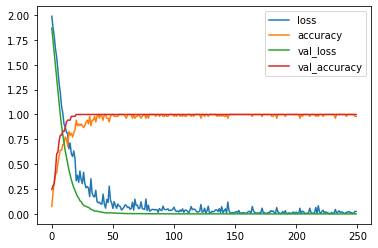

In [42]:
pd.DataFrame(history.history).plot()

In [43]:
model.save('chatbot_model.h5', history)
print("model Saved")

model Saved
